# **Regression**

El objetivo de esta aplicación de proyecto se puede separar en las siguientes fases:

1. **Definición del problema**. El estudiante debe definir un problema a ser resuelto, basado en la selección de un conjunto de datos de un problema que sea de su interés. Es importante que los datos seleccionados correspondan a un problema de regresión de forma que cumpla con el objetivo de la sección de este proyecto. Si la selección de los datos es complicada, como sugerencia pueden tomar el que sea de su interés de las siguientes páginas:

2. **Preparación de datos:** Limpieza y extracción de información estadística básica en los datos analizados. En esta fase las características de las bases de datos deben ser mencionadas (datos nulos, datos sesgados, datos atípicos, datos imbalanceados, distribución de datos, etc.), así como el proceso y decisiones tomadas para procesar y limpiar estos datos.  Incluir gráficos que muestren el comportamiento de los datos y explicar lo que se observa en el gráfico. 

3. **Procesar modelo de regresión:** Aplicar al menos 4 modelos de regresión para estimar el mapeo de los datos. La intención principal es hacer una comparación del performance de cada modelo, incluyendo la mención de la complejidad (número de parámetros y tiempo de ejecución). Añadir un método de ajuste de hiperparámetros para mejorar el performance del modelo. Crear un conjunto de datos "nuevos" donde se prediga la variable objetivo para esos nuevos datos. 

4. **Discusión de los resultados:** Basado en los resultados de la comparación y performance de los modelos, generar una sección de conclusiones donde se hable de las ventajas y desventajas de los modelos propuestos. 

## **1. Data definition** ##

This is a dataset that combines socio-economic data from the 1990 US Census,law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR. The objective of this proyect is to predict **violent crimes per capita** ("ViolentCrimesPerPop") in each US community from the dataset. 
The dataset can be found here: https://archive.ics.uci.edu/dataset/183/communities+and+crime

Some thing to take into consideration before reading this notebook: 

- There are some location features like: **state**, **county**, **community**, **communityname** that won't be used to predict because that may perpetuate bias against certain communities. 
- Because the objective feature is **per Capita** we'll try to create relative values to the total community population, so the size of the community and their absolute values don't biase the algorithm. For example: **Number of sworn full-time police officers in field operations** will be change to **Number of sworn full-time police officers in field operations per capita**
- **Fold** feature wont be used.
- All demographics porcentages, means and medians are from each community, because the dataset granularity is by communities
- **RacialMatchCommPol** is the measure of the racial match between the community and the police force. High values indicate proportions in the community and police force are similar
- **LemasGangUnitDeploy** Encoding:
    - No unit = 0
    - There's unit = 1
    - Part time unit = 0.5

For detailed description of each feature run the code below

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [92]:
columns = pd.read_csv('columns.csv').Feature.to_list()

with open('communities.data', 'r') as file:
    data = []
    for line in file:
        row = line.strip().split(',')
        data.append(row)


df = pd.DataFrame(data,columns=columns)

In [ ]:
#Run this code below to see all columns name and their meaning
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.read_csv('columns.csv')

In [136]:
df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


## **2. Data Preparation** ##

In [95]:
(df.isna().sum() > 0).sum()

0

Seems like there are no nulls, but let's see if this is true

In [96]:
#Converting object columns to their correct type
colsWithErrors = []
for col in [col for col in df.columns if col not in ('state','county','community','communityname','fold')]:
    try:
        df[col] = df[col].astype('float64')

    except Exception as e:
        colsWithErrors.append(col)
        print(f"Column - {col} had the following problem: {e}")


Column - OtherPerCap had the following problem: could not convert string to float: '?'
Column - LemasSwornFT had the following problem: could not convert string to float: '?'
Column - LemasSwFTPerPop had the following problem: could not convert string to float: '?'
Column - LemasSwFTFieldOps had the following problem: could not convert string to float: '?'
Column - LemasSwFTFieldPerPop had the following problem: could not convert string to float: '?'
Column - LemasTotalReq had the following problem: could not convert string to float: '?'
Column - LemasTotReqPerPop had the following problem: could not convert string to float: '?'
Column - PolicReqPerOffic had the following problem: could not convert string to float: '?'
Column - PolicPerPop had the following problem: could not convert string to float: '?'
Column - RacialMatchCommPol had the following problem: could not convert string to float: '?'
Column - PctPolicWhite had the following problem: could not convert string to float: '?'
C

In [97]:
df.replace({"?":np.nan},inplace=True)

In [98]:
for col in colsWithErrors:
    df[col] = df[col].astype('float64')

Now let's see how many null do we have

In [99]:
nulls = pd.DataFrame(df.isna().sum(),columns=["amount"])
nulls = nulls.loc[nulls.amount > 0].sort_values(by="amount",ascending=False)
nulls["nullPercentage"] = round((nulls.amount / df.shape[0])*100,2)
nulls

,amount,nullPercentage
PctPolicWhite,1675,84.00
PctPolicBlack,1675,84.00
LemasGangUnitDeploy,1675,84.00
LemasPctPolicOnPatr,1675,84.00
PolicOperBudg,1675,84.00
PolicCars,1675,84.00
PolicAveOTWorked,1675,84.00
NumKindsDrugsSeiz,1675,84.00
OfficAssgnDrugUnits,1675,84.00
PctPolicMinor,1675,84.00


Discovering data behavior

In [ ]:

numerical_cols = df.select_dtypes(include=['number']).columns

# Calculate the number of rows 
num_features = len(numerical_cols)
num_cols = 5
num_rows = (num_features - 1) // num_cols + 1

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4), sharey=True)  # Adjust the figsize as needed
axes = axes.flatten()

# Plot histograms for each column
for i, col in enumerate(numerical_cols):
    ax = axes[i]
    df[col].plot(kind='hist', ax=ax, bins=10) 
    ax.set_title(col)

# Remove any empty subplots if the number of features is not a multiple of 5
for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


Will be easier to look at the histograms of the features with the most correlation with the objective field

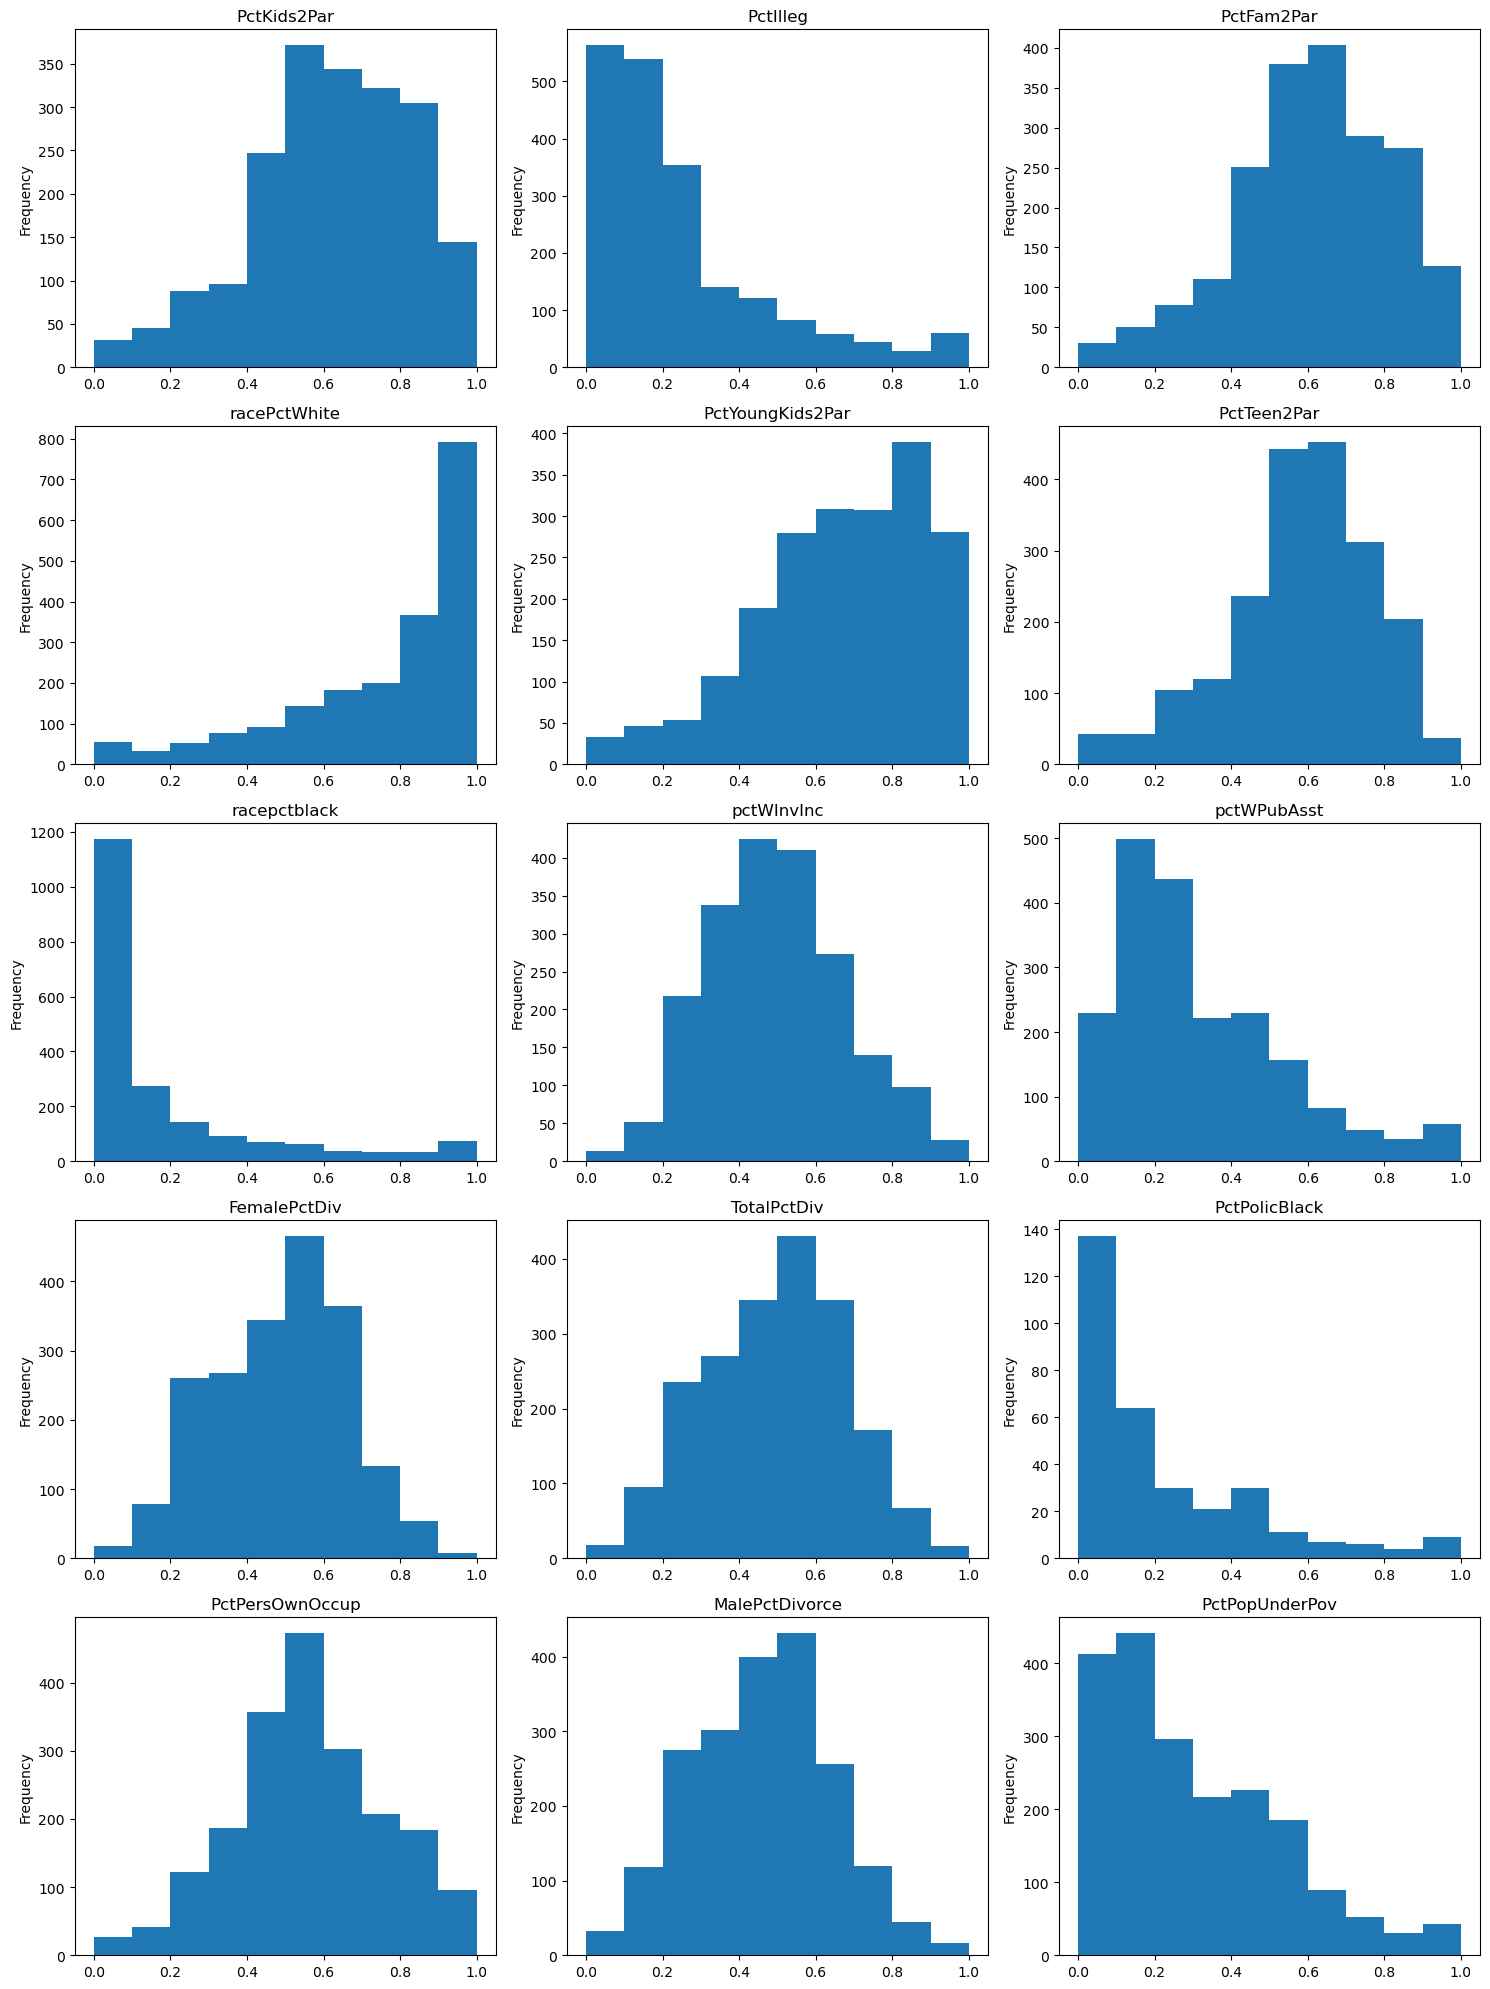

In [151]:
mostCorrelated = pd.DataFrame(abs(df.corr(numeric_only=True)
                 ['ViolentCrimesPerPop']).sort_values(ascending=False)[1:16] #First 15 features
                 ).index


numerical_cols = df[mostCorrelated].select_dtypes(include=['number']).columns

# Calculate the number of rows and columns needed for the grid
num_features = len(numerical_cols)
num_rows = (num_features - 1) // 3 + 1
num_cols = min(num_features, 3)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))  # Adjust the figsize as needed

# Flatten the 2D array of subplots
axes = axes.flatten()

# Plot histograms for each column
for i, col in enumerate(numerical_cols):
    ax = axes[i]
    df[col].plot(kind='hist', ax=ax, bins=10)  # Adjust the number of bins as needed
    ax.set_title(col)

# Remove any empty subplots if the number of features is not a multiple of 3
for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()
